In [10]:
import os
import sys
sys.path.append("src")
from PIL import Image
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from dataloader import CustomDataset
from model import model_x
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
directory = "data"
data = []
visualization = {}

for idx, lbl in enumerate(os.listdir(directory)):
    folder_dir = os.path.join(directory, lbl)
    for img_file in os.listdir(folder_dir):
        img = Image.open(os.path.join(folder_dir,img_file))
        img_bw = img.convert("L")
        np_img = np.array(img)
        data.append((np_img, idx))

        if lbl not in visualization:
            visualization[lbl] = os.path.join(folder_dir,img_file)

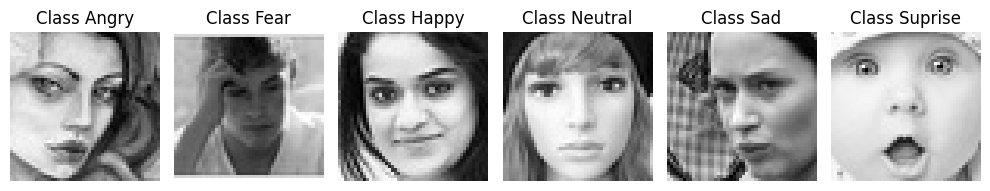

In [3]:
plt.figure(figsize=(10, 5))
idx = 0
for lbl, img_path in visualization.items():
    idx += 1
    img = Image.open(img_path)
    img_bw = img.convert("L")  # Convert the image to black and white (grayscale)
    plt.subplot(1, len(visualization), idx)
    plt.imshow(img_bw, cmap='gray')  # Display the grayscale image
    plt.title(f"Class {lbl}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [101]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(10),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(0.75, 1.333))  
])

transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    augmentation_transform,  # Apply data augmentation
    transforms.ToTensor()    # Convert the image to a tensor
])


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1 (10% of the original data)

train_dataset = CustomDataset(data=train_data, transform=transform)
test_dataset = CustomDataset(data=test_data, transform=transform)
val_dataset = CustomDataset(data=val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_x(in_channels=1, out_channels=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007, weight_decay=0.10)
train_accuracy_arr = []
val_accuracy_arr = []
epoches = 200
for epoch in range(epoches):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epoches}', leave=False)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _ , predicted = torch.max(outputs, dim=1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / train_total
    train_accuracy_arr.append(train_accuracy)
    print("Train_loss: ", train_loss, "Train_accuracy: ", train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()*images.size(0)
        _,predicted = torch.max(outputs,1)
        val_total+=labels.size(0)
        val_correct += (predicted==labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100.0 * val_correct / val_total
    val_accuracy_arr.append(val_accuracy)
    print("Val_loss: ", val_loss, "Val_accuracy: ", val_accuracy)


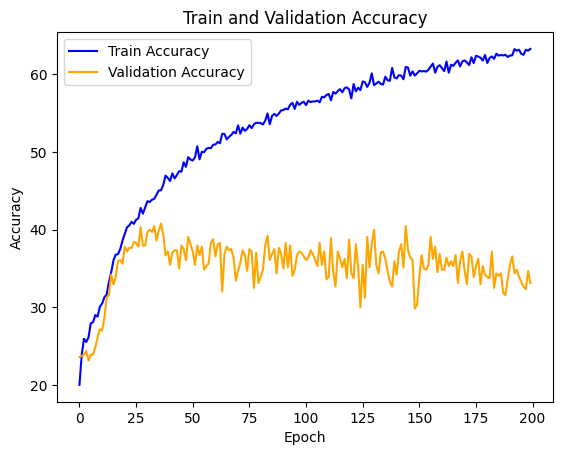

In [104]:
plt.plot(train_accuracy_arr, label='Train Accuracy', color='blue')
plt.plot(val_accuracy_arr, label='Validation Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

# Overfitting
    An obvious graph of overfitting is observed above, due to weight decay plus data augmentation plus dropout in 200 iterations. When I remove the regularizors, I obtain a graph like 20 percent validation accuracy and 93 percent train accuracy, which is heavily overfitted. Hence I will try another model structure with residual blocks, plus I will try to utilize pretrained weights.